### 分析关键问题
1. x_value = batch-0.5;#2 * batch.astype(np.float32) - 1
1. 以上必须将数据范围归一化到-1~1 或-0.5~0.5

In [2]:
#Import the libraries we will need.
# -*- coding:utf-8 -*-
import tensorflow as tf
import numpy as np
from tensorflow.contrib import rnn
from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline

In [3]:
# 设置 GPU 按需增长
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

# 首先导入数据，看一下数据的形式
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
print mnist.train.images.shape

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(55000, 784)


### 首先设置好模型用到的各个超参数

In [4]:
#
lr = 1e-3
# 在训练和测试的时候，我们想用不同的 batch_size.所以采用占位符的方式
#batch_size = tf.placeholder(tf.int32)  # 注意类型必须为 tf.int32
# 在 1.0 版本以后请使用 ：
keep_prob = tf.placeholder(tf.float32, [])
batch_size = tf.placeholder(tf.int32, [])

# 每个时刻的输入特征是28维的，就是每个时刻输入一行，一行有 28 个像素
input_size = 28
# 时序持续长度为28，即每做一次预测，需要先输入28行
timestep_size = 28
# 每个隐含层的节点数
hidden_size = 28*28
# LSTM layer 的层数
layer_num = 4
# 最后输出分类类别数量，如果是回归预测的话应该是 1
class_num = 10

_X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, class_num])
keep_prob = tf.placeholder(tf.float32)


### 开始搭建 RNN 模型

In [5]:
timestep_size=28/28
input_size=28*28
X = tf.reshape(_X, [-1, timestep_size, input_size])


h1_size = 150  
h2_size = 300  
z_size = 100
img_size = 28 * 28  

def build_generator(z_prior):  
    w1 = tf.Variable(tf.truncated_normal([z_size, h1_size], stddev=0.1), name="g_w1", dtype=tf.float32)  
    b1 = tf.Variable(tf.zeros([h1_size]), name="g_b1", dtype=tf.float32)  
    h1 = tf.nn.relu(tf.matmul(z_prior, w1) + b1)  
    w2 = tf.Variable(tf.truncated_normal([h1_size, h2_size], stddev=0.1), name="g_w2", dtype=tf.float32)  
    b2 = tf.Variable(tf.zeros([h2_size]), name="g_b2", dtype=tf.float32)  
    h2 = tf.nn.relu(tf.matmul(h1, w2) + b2)  
    w3 = tf.Variable(tf.truncated_normal([h2_size, img_size], stddev=0.1), name="g_w3", dtype=tf.float32)  
    b3 = tf.Variable(tf.zeros([img_size]), name="g_b3", dtype=tf.float32)  
    h3 = tf.matmul(h2, w3) + b3  
    x_generate = tf.nn.tanh(h3)  
    g_params = [w1, b1, w2, b2, w3, b3]  
    return x_generate, g_params  

def build_discriminator(x_data, x_generated, keep_prob):  
    x_in = tf.concat([x_data], 0)  
    w1 = tf.Variable(tf.truncated_normal([img_size, h2_size], stddev=0.1), name="d_w1", dtype=tf.float32)  
    b1 = tf.Variable(tf.zeros([h2_size]), name="d_b1", dtype=tf.float32)  
    h1 = tf.nn.dropout(tf.nn.relu(tf.matmul(x_in, w1) + b1), keep_prob)
    
    w2 = tf.Variable(tf.truncated_normal([h2_size, h1_size], stddev=0.1), name="d_w2", dtype=tf.float32)  
    b2 = tf.Variable(tf.zeros([h1_size]), name="d_b2", dtype=tf.float32)  
    h2 = tf.nn.dropout(tf.nn.relu(tf.matmul(h1, w2) + b2), keep_prob)  
    
    w3 = tf.Variable(tf.truncated_normal([h1_size, 1], stddev=0.1), name="d_w3", dtype=tf.float32)  
    b3 = tf.Variable(tf.zeros([1]), name="d_b3", dtype=tf.float32)  
    h3 = tf.matmul(h2, w3) + b3  
    y_data = tf.nn.sigmoid(h3)
    
    x_in = tf.concat([x_generated], 0)  
    h1 = tf.nn.dropout(tf.nn.relu(tf.matmul(x_in, w1) + b1), keep_prob)
    h2 = tf.nn.dropout(tf.nn.relu(tf.matmul(h1, w2) + b2), keep_prob)  
    h3 = tf.matmul(h2, w3) + b3  
    y_generated = tf.nn.sigmoid(h3)
    d_params = [w1, b1, w2, b2, w3, b3]  
    
    return y_data, y_generated, d_params  



### 设置一个GAN限定输出层必须类似字符型

In [6]:
outputs = list()
h_state,g_params=build_generator(X[:, 0, 200:300])
outputs.append(h_state)

X_re=tf.reshape(X,[-1,784])

y_data,y_generated, d_params  = build_discriminator(X_re,h_state, keep_prob)

d_loss = - (tf.log(y_data) + tf.log(1 - y_generated))
g_loss = - tf.log(y_generated)

optimizer_d = tf.train.AdamOptimizer(0.0001)
optimizer_g = tf.train.AdamOptimizer(0.0001)
d_trainer = optimizer_d.minimize(d_loss, var_list=d_params)
g_trainer = optimizer_g.minimize(g_loss, var_list=g_params)

In [26]:
sess.run(tf.global_variables_initializer())

In [1]:
for i in range(80000):
    _batch_size = 256
    batch,batch_y = mnist.train.next_batch(_batch_size) 
    x_value = batch-0.5;#2 * batch.astype(np.float32) - 1
    if (i+1)%2000 == 0:
        d_v,g_v = sess.run([d_loss,g_loss], feed_dict={
            _X:x_value, y: batch_y, keep_prob: 1.0, batch_size: _batch_size})
        # 已经迭代完成的 epoch 数: mnist.train.epochs_completed
        print "Iter%d, step %d, training accuracy %g %g %g" % ( mnist.train.epochs_completed, (i+1), 0,np.exp(-np.mean(d_v)),np.exp(-np.mean(g_v)))
    
    sess.run(d_trainer, feed_dict={_X: x_value, y: batch_y, keep_prob: 0.7, batch_size: _batch_size})
    sess.run(g_trainer, feed_dict={_X: x_value, y: batch_y, keep_prob: 0.7, batch_size: _batch_size})


NameError: name 'mnist' is not defined

### 可视化看看 LSTM 的是怎么做分类的

In [21]:
num=21

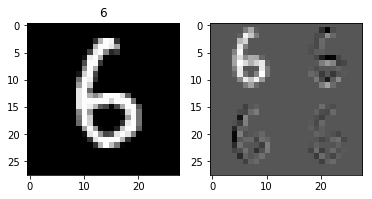

In [22]:
#
import matplotlib.pyplot as plt
X3 = mnist.test.images[num]
y_batch = mnist.test.labels[num]

img3 = X3.reshape([28, 28])
plt.subplot(1,2,1)
plt.imshow(img3, cmap='gray')
plt.title(np.argmax(y_batch) )

import pywt,cv2
cA2, (cH2, cV2, cD2)=pywt.wavedec2(np.float32(img3)/255,'haar',level=1);
X2=np.vstack((np.hstack((cA2, cH2)),np.hstack((cV2, cD2))))
plt.subplot(1,2,2)
plt.imshow(X2,cmap='gray')

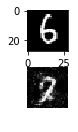

In [23]:
#
X3.shape = [-1, 784]
y_batch.shape = [-1, class_num]
#
outputs_v=sess.run([outputs], feed_dict={
            _X: X3, y: y_batch, keep_prob: 1.0, batch_size: 1})

plt.subplot(4, 7, 1)
X3_outputs = np.array(outputs_v);
plt.imshow(np.reshape(X3,[28,28]),cmap='gray')
X3_re=np.reshape(X3_outputs,[-1,28, 28])
for i in xrange(X3_re.shape[0]):
    plt.subplot(4, 7, i+8)
    plt.imshow(X3_re[i,:,:],cmap='gray')
    plt.axis('off')
plt.show()
